# Model Distribution

In [2]:
from datasets import Dataset, load_from_disk
import pandas as pd
from datasets import load_from_disk
from collections import defaultdict, deque
from tqdm import tqdm
import random
import numpy as np



In [3]:
from typing import Union
import pandas as pd
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset

def compute_model_frequencies(data: Union[pd.DataFrame, Dataset], model_name: str, batch_size: int):
    is_dataframe = isinstance(data, pd.DataFrame)
    
    if is_dataframe:
        total_size = len(data)
    else:
        total_size = data.num_rows

    num_batches = math.ceil(total_size / batch_size)
    frequency_by_batch = {}

    for batch_idx in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, total_size)

        if is_dataframe:
            batch_data = data.iloc[start_idx:end_idx]
            count_a = (batch_data['model_a'] == model_name).sum()
            count_b = (batch_data['model_b'] == model_name).sum()
        else:
            batch_data = data.select(range(start_idx, end_idx))
            model_a_vals = np.array(batch_data['model_a'])
            model_b_vals = np.array(batch_data['model_b'])

            count_a = np.count_nonzero(model_a_vals == model_name)
            count_b = np.count_nonzero(model_b_vals == model_name)

        frequency_by_batch[batch_idx] = count_a + count_b

    return frequency_by_batch

import matplotlib.pyplot as plt
def moving_average(data, window_size=21):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def plot_model_frequency(frequency_by_batch: dict, model_name: str, title=""):
    batches = list(frequency_by_batch.keys())
    counts = list(frequency_by_batch.values())
    
    smoothed_counts = moving_average(counts, window_size=21) 

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(batches, smoothed_counts, label=model_name, linewidth=2.5)
    ax.set_title(f'Frequency of "{model_name}" Across Batches {title}')
    ax.set_xlabel('Batch Number')
    ax.set_ylabel('Total Count')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return fig



In [4]:
def load_data(path):
    return load_from_disk(path)


In [13]:
# PARAMS
eps = [0.01, 0.005, 0.001, 0.0005, 0.0001]
gammas = [0.99, 0.995, 0.999, 0.9995, 0.9999]
train_data_path = '/home/joseph/train_data'
chrono_data_path = '/home/joseph/train_data/chrono_train_data'

         

In [ ]:
paths = [chrono_data_path, ]

for i in range(len(eps)):
    for j in range(len(gammas)):
        paths.append(train_data_path + f'/geom_gamma_{gammas[j]}_eps_{eps[i]}_min')

titles = [path.split('/')[-1] for path in paths]
datas = [load_data(path) for path in paths]

In [1]:
# # model_name = 'gpt-3.5-turbo-0613'
# model_name = 'gpt-4-turbo-2024-04-09',

# batch_sizes = [512 for _ in range(len(paths))]

# for title, data, batch_size in zip(titles, datas, batch_sizes):
#     freq = compute_model_frequencies(data=data, model_name=model_name, batch_size=batch_size)
#     plot_model_frequency(freq, model_name=model_name, title = title)

# Random Extra Stuff

In [8]:
model_name = 'gpt-4-turbo-2024-04-09',

batch_sizes = [512, int(512/0.8), int(len(datas[2]) / len(datas[0]) * 512)]
frequency_results = []

for title, data, batch_size in zip(titles, datas, batch_sizes):
    freq = compute_model_frequencies(data, model_name, batch_size)
    frequency_results.append((title, list(freq.keys()), moving_average(list(freq.values()))))

Processing batches: 100%|██████████| 4393/4393 [00:15<00:00, 291.86it/s]


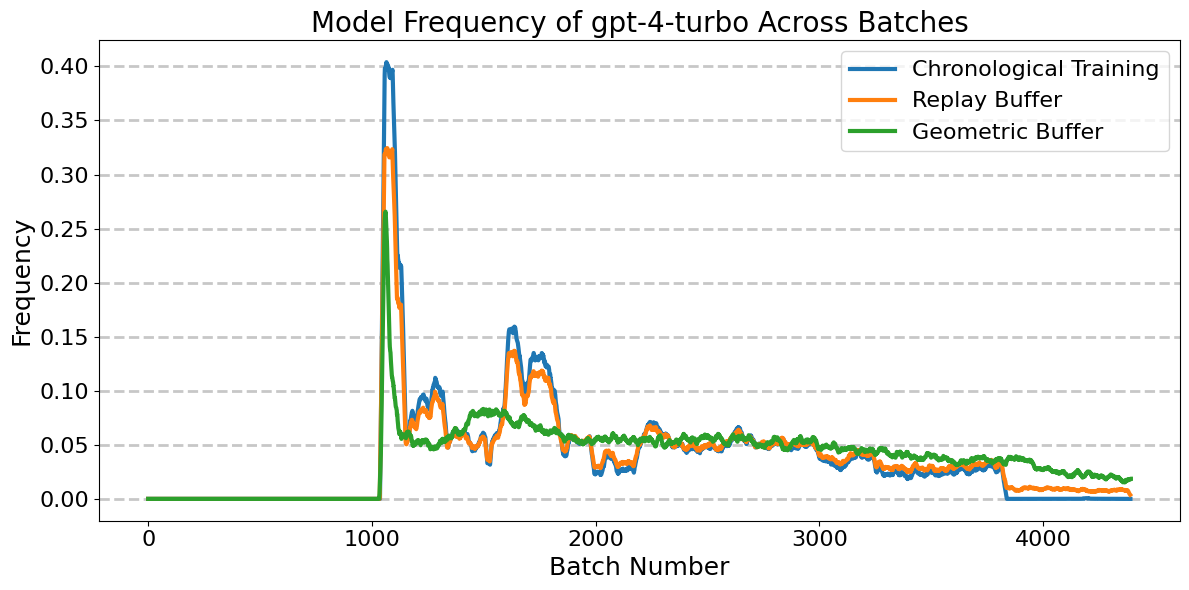

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

titles = ["Chronological Training", "Replay Buffer", "Geometric Buffer"]
n_shift = 360
for idx, (title, batches, smoothed_counts) in enumerate(frequency_results):
    smoothed_counts = [smooth / batch_sizes[idx] for smooth in smoothed_counts]
    if idx == 2:
        smoothed_counts = [0] * n_shift + smoothed_counts[:-n_shift]
        
    ax.plot(batches, smoothed_counts, label=titles[idx], linewidth=3.0)  # thicker line

# Set bigger fonts
ax.set_title('Model Frequency of gpt-4-turbo Across Batches', fontsize=20)
ax.set_xlabel('Batch Number', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.tick_params(axis='both', labelsize=16)  # increase tick label font size
ax.legend(fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7, linewidth=2.0)

plt.tight_layout()
plt.show()


In [69]:
df_subset = df.iloc[512:1024]

# Count appearances of "gemini 1206" in model_a and model_b
count_a = (df_subset['model_a'] == 'gemini-exp-1206').sum()
count_b = (df_subset['model_b'] == 'gemini-exp-1206').sum()

print("Count in model_a:", count_a)
print("Count in model_b:", count_b)

Count in model_a: 13
Count in model_b: 7


In [79]:
df_subset = df.iloc[:4000]

# Get all unique models from both columns
models_in_a = set(df_subset['model_a'].unique())
models_in_b = set(df_subset['model_b'].unique())

# Union of both sets
sorted(models_in_a.union(models_in_b))

['alpaca-13b',
 'chatglm-6b',
 'dolly-v2-12b',
 'fastchat-t5-3b',
 'gpt-3.5-turbo-0314',
 'gpt-4-0314',
 'koala-13b',
 'llama-13b',
 'oasst-pythia-12b',
 'stablelm-tuned-alpha-7b',
 'vicuna-13b']

In [40]:
def print_stats(eps, gamma):
    print(f"Gamma: {gamma}, Epsilon: {eps}")
    print("Time to saturation", math.log(eps)/math.log(gamma))
    print("Saturation deferall", 1/eps)
    


In [ ]:
eps = 0.001
gamma = 0.999

print_stats(eps, gamma)

Gamma: 0.9995, Epsilon: 0.001
Time to saturation 13812.056392431188
Saturation deferall 1000.0
